In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates
import matplotlib.cm

plt.style.use('dark_background')


In [2]:
filename = "/Users/baart_f/data/drought/lobith/AfvoerenLobith.xlsx"

In [5]:
df = pd.read_excel(filename, sheet_name='Lobith')

In [19]:
lobith_df = df.melt(
    id_vars=('maand', 'dag'), 
    value_vars=range(1901, 2024), 
    value_name='discharge', 
    var_name='year'
)

In [67]:
lobith_df = lobith_df.dropna(subset=['discharge'])
lobith_df['t'] = lobith_df.apply(
    lambda row: pd.Timestamp(year=row['year'], month=row['maand'], day=row['dag']),
    axis=1
)
lobith_df['t2000'] = lobith_df.apply(
    lambda row: pd.Timestamp(year=2000, month=row['maand'], day=row['dag']),
    axis=1
)

lobith_df['doy'] = lobith_df['t'].dt.dayofyear

In [68]:
annual_min_df = lobith_df.groupby('year').min()[['t', 'discharge']]

In [69]:
annual_min_df = annual_min_df[annual_min_df.index < 2023]

In [85]:
annual_min_df.sort_values('discharge').head(n=10)

,t,discharge
year,,
1929,1929-01-01,575.0
1947,1947-01-01,620.0
1949,1949-01-01,635.0
1963,1963-01-01,665.0
1921,1921-01-01,670.0
2022,2022-01-01,679.0
1954,1954-01-01,680.0
1953,1953-01-01,685.0
1959,1959-01-01,715.0


Text(0.5, 0, 'Day of year')

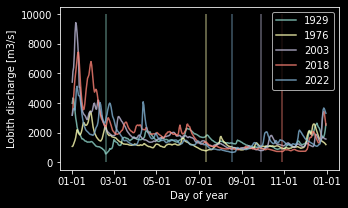

In [122]:
fig, ax = plt.subplots(figsize=(5, 3))

colors = [x["color"] for x in matplotlib.rcParams['axes.prop_cycle']]
years = [1929, 1976, 2003, 2018, 2022]
for color, year in zip(colors, years):
    selected = lobith_df[lobith_df['year'] == year]
    ax.plot(selected['t2000'], selected['discharge'], label=year, color=color, alpha=0.8)
    min_row = selected.loc[selected['discharge'].idxmin()]
    ax.vlines(min_row['t2000'], 0, 10000, alpha=0.5, color=color)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d'))    
ax.legend(loc='best')
ax.set_ylabel('Lobith discharge [m3/s]')
ax.set_xlabel('Day of year')

In [126]:
fig.tight_layout()
fig
fig.savefig('/Users/baart_f/src/drought-scrolly/example/drought-scrolly/images/figures/lobith.png')

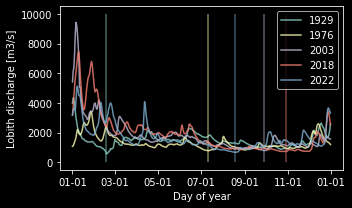